#### Import Modules

In [388]:
import json
import pandas as pd
import re
import random
import matplotlib.pyplot as plt
%matplotlib inline  
from ast import literal_eval as make_tuple
from scipy import sparse
import numpy as np
from pymongo import MongoClient
from nltk.corpus import stopwords
from sklearn import svm
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
import sys
sys.path.append('../machine_learning')
import yelp_ml as yml
reload(yml)
from gensim import corpora, models, similarities, matutils
import tqdm

#### Import Scrapped Reviews

In [10]:
dc_reviews = json.load(open("../Yelp_web_scrapper/dc_reviews.json"))
newyork_reviews = json.load(open("../Yelp_web_scrapper/newyork_reviews.json"))
austin_reviews = json.load(open("../Yelp_web_scrapper/austin_reviews.json"))
chicago_reviews = json.load(open("../Yelp_web_scrapper/chicago_reviews.json"))
la_reviews = json.load(open("../Yelp_web_scrapper/la_reviews.json"))

scrapped_reviews = {'dc': dc_reviews, 'ny': newyork_reviews, 
                    'austin': austin_reviews, 'chicago': chicago_reviews, 
                    'la': la_reviews}

#### Import Hu & Liu (2004) Word Dictionary and Wrangled Large Users

In [3]:
lh_neg = open('../input/negative-words.txt', 'r').read()
lh_neg = lh_neg.split('\n')
lh_pos = open('../input/positive-words.txt', 'r').read()
lh_pos = lh_pos.split('\n')
users = json.load(open("cleaned_large_user_dictionary.json"))
word_list = list(set(lh_pos + lh_neg))

Connect to the AWS Instance and get the restaurant reviews from the cleaned data database

In [11]:
ip = '54.175.170.119'
conn = MongoClient(ip, 27017)
conn.database_names()
db = conn.get_database('cleaned_data')
reviews = db.get_collection('restaurant_reviews')

# Testing

1. Supply User ID
2. Get all restaurant IDs that the user has reviewed
3. Do a random 75 (training)/25(testing) split of the restaurant IDs
4. For the training sample, get all of the **user's** reviews for those restaurants
5. For each restaurant in the testing sample, get all of that **restaurant's** reviews
6. Train each of the (feature, model) combinations on the **reviews** in the training sample
7. For each **review** in the testing sample, classify that review using the model
    1. If the total proportion of positive reviews is greater than 70% for **each** restaurant, classify that **restaurant's** rating as positive.
    2. Else, classify  that **restaurant's** rating as negative
8. For each restaurant's predicted rating, check against what the **user** _actually_ thought 9. Use these to determine log-loss, accuracy, and precision 

The features and models we use are:

#### Features:
                                 
1. (Sentiment %, TF-IDF w/ (2,2) N-Gram, LSA)
2. (Sentiment %, LSA)
3. (TF-IDF w/ (2,2) N-Gram, LDA, LSA)
4. (Sentiment %, TF-IDF w/ (2,2) N-Gram, LDA, LSA)
                  
#### Models:
1. Linear Support Vector Machine
2. Random Forest
3. Naive Bayes

In [4]:
string_keys_dict = {}
for j in tqdm.tqdm(range(146, 147)):
    
    #Generate a dataframe that has the user's review text, review rating, and restaurant ID
    test_results = {}
    user_df = yml.make_user_df(users[users.keys()[j]])
    
    #Only predict for the user if they have at least 20 bad ratings
    if len([x for x in user_df['rating'] if x < 4]) < 20:
        string_keys_dict[str(users.keys()[j])] = test_results
        continue
    else:
        business_ids = list(set(user_df['biz_id']))
        restreview = {}
        
        #Create a training and test sample from the user reviewed restaurants
        #using a random 25% subset of all the restaurants the user has reviewed
        split_samp = .25
        len_random = int(len(business_ids) * split_samp)
        test_set = random.sample(business_ids, len_random)
        training_set = [x for x in business_ids if x not in test_set]
        sub_train_reviews, train_labels, train_reviews, train_ratings = [], [], [], []

        #Create a list with the tuple (training review, training rating) 
        for rest_id in training_set:
            train_reviews.append((user_df[user_df['biz_id'] == rest_id]['review_text'].iloc[0],
                                     user_df[user_df['biz_id'] == rest_id]['rating'].iloc[0]))

        #Note that the distribution is heavily skewed towards good reviews. 
        #Therefore, we create a training sample with the same amount of
        #positive and negative reviews
        sample_size = min(len([x[1] for x in train_reviews if x[1] < 4]),
                              len([x[1] for x in train_reviews if x[1] >= 4]))

        bad_reviews = [x for x in train_reviews if x[1] < 4]
        good_reviews = [x for x in train_reviews if x[1] >= 4]

        for L in range(0, int(float(sample_size)/float(2))):
            sub_train_reviews.append(bad_reviews[L][0])
            sub_train_reviews.append(good_reviews[L][0])
            train_labels.append(bad_reviews[L][1])
            train_labels.append(good_reviews[L][1])

        #Make the train labels binary
        train_labels = [1 if x >=4 else 0 for x in train_labels]
        
        #Sanity check for non-empty training reviews
        if not sub_train_reviews:
            string_keys_dict[str(users.keys()[j])] = test_results
            continue
        else:
            for i in range(0, len(business_ids)):
                rlist = []
                for obj in reviews.find({'business_id':business_ids[i]}):
                    rlist.append(obj)
                restreview[business_ids[i]] = rlist

            restaurant_df = yml.make_biz_df(users.keys()[j], restreview)

            #Make a FeatureUnion object with the desired features then fit to train reviews
            feature_selection = {"sent_tf":(True, True, False), 
                                 "sent": (True,False,False),
                                 "tf_lda": (False,True,True), 
                                 "all": (True, True, True)}

            for feature in feature_selection.keys():
                #Make a FeatureUnion object with the desired features then fit to train reviews
                comb_features = yml.make_featureunion(sent_percent=feature_selection[feature][0], 
                                                      tf = feature_selection[feature][1], 
                                                      lda = feature_selection[feature][2])

                delta_vect = None
                comb_features.fit(sub_train_reviews)
                train_features = comb_features.transform(sub_train_reviews)

                #Fit LSI model and return number of LSI topics
                lsi, topics, dictionary = yml.fit_lsi(sub_train_reviews)
                train_lsi = yml.get_lsi_features(sub_train_reviews, lsi, topics, dictionary)

                #Stack the LSI and combined features together
                train_features = sparse.hstack((train_features, train_lsi))
                train_features = train_features.todense()

                #fit each model in turn 
                model_runs = {"svm": (True, False, False),
                              "rf": (False, True, False), 
                              "naive_bayes": (False, False, True)}

                for model_run in model_runs.keys():
                    clf = yml.fit_model(train_features, train_labels, svm_clf = model_runs[model_run][0], 
                                    RandomForest = model_runs[model_run][1], 
                                        nb = model_runs[model_run][2])
                    threshold = 0.7
                    error = yml.test_user_set(test_set, clf, restaurant_df, user_df, comb_features, 
                                              threshold, lsi, topics, dictionary, delta_vect)
                    test_results[str((feature, model_run))] = (yml.get_log_loss(error), 
                                                    yml.get_accuracy_score(error), 
                                                    yml.get_precision_score(error))
                
    string_keys_dict[str(users.keys()[j])] = test_results
            
with open('test_results.json', 'wb') as fp:
    json.dump(string_keys_dict, fp)

  0%|          | 0/1 [00:00<?, ?it/s]/Users/robertsonwang/anaconda2/lib/python2.7/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/robertsonwang/anaconda2/lib/python2.7/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/robertsonwang/anaconda2/lib/python2.7/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
100%|██████████| 1/1 [13:22<00:00, 802.10s/it]


#### The best performing (feature, model) combination for this user was a combination of **all** of the features in a linear support vector machine.

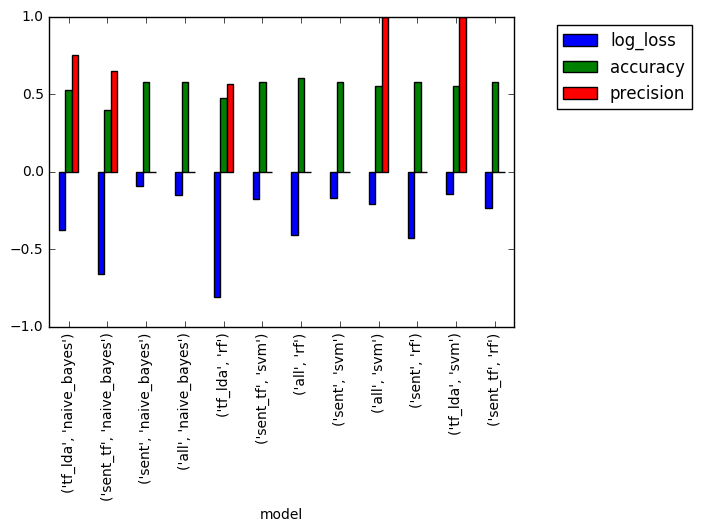

In [342]:
test_results_df = pd.DataFrame.from_dict(test_results, orient = 'index')
test_results_df['model'] = test_results_df.index
test_results_df.columns = ['log_loss', 'accuracy', 'precision', 'model']
test_results_df.plot(x = 'model', y = ['log_loss', 'accuracy', 'precision'], kind = 'bar')
ax = plt.subplot(111)
ax.legend(bbox_to_anchor=(1.4, 1))
plt.show()

# Make a Recommendation

In [475]:
top_results = []
#Get feature and model combination that yields the highest precision
for key in test_results.keys():
    feat_model = make_tuple(key)
    if not top_results:
        top_results = [(feat_model,test_results[key][2])]
    else:
        if test_results[key][2] > top_results[0][1]:
            top_results.pop()
            top_results = [(feat_model, test_results[key][2])]
# feat_result = top_results[0][0][0]
# model_result = top_results[0][0][1]
feat_result = 'tf_lda'
model_result = 'svm'
for j in tqdm.tqdm(range(146, 147)):
    user_df = yml.make_user_df(users[users.keys()[j]])
    business_ids = list(set(user_df['biz_id']))

    #Create a list of training reviews and training ratings
    for rest_id in business_ids:
        train_reviews.append((user_df[user_df['biz_id'] == rest_id]['review_text'].iloc[0],
                                 user_df[user_df['biz_id'] == rest_id]['rating'].iloc[0]))

    #Create an even sample s.t. len(positive_reviews) = len(negative_reviews)
    sample_size = min(len([x[1] for x in train_reviews if x[1] < 4]),
                          len([x[1] for x in train_reviews if x[1] >= 4]))
    
    bad_reviews = [x for x in train_reviews if x[1] < 4]
    good_reviews = [x for x in train_reviews if x[1] >= 4]
    
    train_labels = []
    sub_train_reviews = []
    for L in range(0, int(float(sample_size)/float(2))):
        sub_train_reviews.append(bad_reviews[L][0])
        sub_train_reviews.append(good_reviews[L][0])
        train_labels.append(bad_reviews[L][1])
        train_labels.append(good_reviews[L][1])
        
    #Make the train labels binary
    train_labels = [1 if x >=4 else 0 for x in train_labels]
    
    #Fit LSI model and return number of LSI topics
    lsi, topics, dictionary = yml.fit_lsi(sub_train_reviews)

    #Make a FeatureUnion object with the desired features then fit to train reviews
    feature_selection = {"sent_tf":(True, True, False), 
                         "sent": (True,False,False),
                         "tf_lda": (False,True,True), 
                         "all": (True, True, True)}
    top_feature = feature_selection['all']
    
    comb_features = yml.make_featureunion(sent_percent=top_feature[0], 
                                          tf = top_feature[1], 
                                          lda = top_feature[2])
        
    comb_features.fit(sub_train_reviews)
    train_features = comb_features.transform(sub_train_reviews)
    train_lsi = yml.get_lsi_features(sub_train_reviews, lsi, topics, dictionary)
    train_features = sparse.hstack((train_features, train_lsi))
    train_features = train_features.todense()

    #Fit LSI model and return number of LSI topics
    lsi, topics, dictionary = yml.fit_lsi(sub_train_reviews)
        
    #Get the top performing model and fit using that model
    model_runs = {"svm": (True, False, False),
                  "rf": (False, True, False), 
                  "naive_bayes": (False, False, True)}
    
    top_model = model_runs['svm']
    clf = yml.fit_model(train_features, train_labels, svm_clf = top_model[0], 
                RandomForest = top_model[1], 
                    nb = top_model[2])

    threshold = 0.7
    user_results = {}
    for key in scrapped_reviews.keys():
        user_results[key] = yml.make_rec(scrapped_reviews[key], clf, threshold, comb_features, 
                                lsi, topics, dictionary)

  0%|          | 0/1 [00:00<?, ?it/s]/Users/robertsonwang/anaconda2/lib/python2.7/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
100%|██████████| 1/1 [04:18<00:00, 258.80s/it]


In [476]:
################################################################
#Collect the results into a list of tuples, then select the top
#5 most confident good recs and top 5 most confident bad recs 
#for each location
################################################################
tuple_results = {}
for key in user_results.keys():
    tuple_results[key] = []
    for result in user_results[key]:
        tuple_results[key].append((result[1], result[2], result[3]))
    tuple_results[key] = sorted(tuple_results[key], key=lambda tup: tup[1])

### Let's look at the top 5 restaurants for each location

In [477]:
for key in tuple_results.keys():
    print "The top 5 recommendations for " + key + " are: "
    print tuple_results[key][-5:]

The top 5 recommendations for ny are: 
[(u'/biz/daniel-new-york-4', 1.0, 1), (u'/biz/mido-new-york', 1.0, 1), (u'/biz/under-the-bridge-new-york', 1.0, 1), (u'/biz/scarpetta-new-york', 1.0, 1), (u'/biz/kafe-louverture-brooklyn', 1.0, 1)]
The top 5 recommendations for la are: 
[(u'/biz/cocobella-creamery-los-angeles-2', 1.0, 1), (u'/biz/chouchou-santa-monica', 1.0, 1), (u'/biz/cruciferous-los-angeles', 1.0, 1), (u'/biz/baskin-robbins-los-angeles-17', 1.0, 1), (u'/biz/chiguacle-sabor-ancestral-de-mexico-los-angeles', 1.0, 1)]
The top 5 recommendations for austin are: 
[(u'/biz/zocalo-caf%C3%A9-austin-3', 1.0, 1), (u'/biz/counter-3-five-vii-austin', 1.0, 1), (u'/biz/mykonos-waffle-austin', 1.0, 1), (u'/biz/the-doughminican-austin', 1.0, 1), (u'/biz/belly-up-austin-2', 1.0, 1)]
The top 5 recommendations for dc are: 
[(u'/biz/al-volo-washington', 0.94999999999999996, 1), (u'/biz/rappahannock-oyster-bar-washington', 0.94999999999999996, 1), (u'/biz/ristorante-la-perla-of-washington-washington

### Let's look at the bottom 5 restaurants for each location

In [478]:
for key in tuple_results.keys():
    print "The bottom 5 recommendations for " + key + " are: "
    print tuple_results[key][0:5]

The bottom 5 recommendations for ny are: 
[(u'/biz/okonomi-brooklyn', 0.20000000000000001, 0), (u'/biz/umai-ramen-brooklyn-2', 0.25, 0), (u'/biz/saigon-shack-new-york', 0.25, 0), (u'/biz/peaches-hothouse-brooklyn', 0.29999999999999999, 0), (u'/biz/joes-steam-rice-rolls-flushing', 0.34999999999999998, 0)]
The bottom 5 recommendations for la are: 
[(u'/biz/eggslut-venice-los-angeles', 0.20000000000000001, 0), (u'/biz/eastside-market-italian-deli-los-angeles-4', 0.25, 0), (u'/biz/tacos-baja-ensenada-los-angeles-2', 0.25, 0), (u'/biz/tacos-tumbras-a-tomas-los-angeles', 0.25, 0), (u'/biz/aca-grill-los-angeles-2', 0.25, 0)]
The bottom 5 recommendations for austin are: 
[(u'/biz/noble-sandwich-austin-2', 0.20000000000000001, 0), (u'/biz/fat-sals-deli-austin-4', 0.25, 0), (u'/biz/kula-revolving-sushi-bar-austin', 0.29999999999999999, 0), (u'/biz/brooklyn-pie-austin-2', 0.29999999999999999, 0), (u'/biz/general-tsoboy-austin', 0.34999999999999998, 0)]
The bottom 5 recommendations for dc are: 
[(

### Let's take a step back and look at the user's word choice and tone. First let's look at the user_df dataframe, which contains all of the user's reviews and ratings.

In [479]:
user_df = yml.make_user_df(users[users.keys()[j]])
user_df.head()

,biz_id,rating,review_text
0,BM4ivx69oX71Dsveu26Tmw,4,So Wednesday evening I needed milk and cat foo...
1,2BbFeotL85cIaBjSq1SWiA,4,I am getting to this a bit late as I was there...
2,KRsANC7TzP97KMFRA1JqiQ,4,So I wasnt sure where I wanted to eat lunch to...
3,3TnNC-AMuQ4upCtcgtU49w,3,I had a Groupon for this place how many review...
4,5Je2-6KDxPQJZdItfo1ngg,4,For my money the best of the 3 or 4 Asian buff...


In [22]:
# Graph most common word usages

### Let's look at the most important TF-IDF features for our linear SVM model

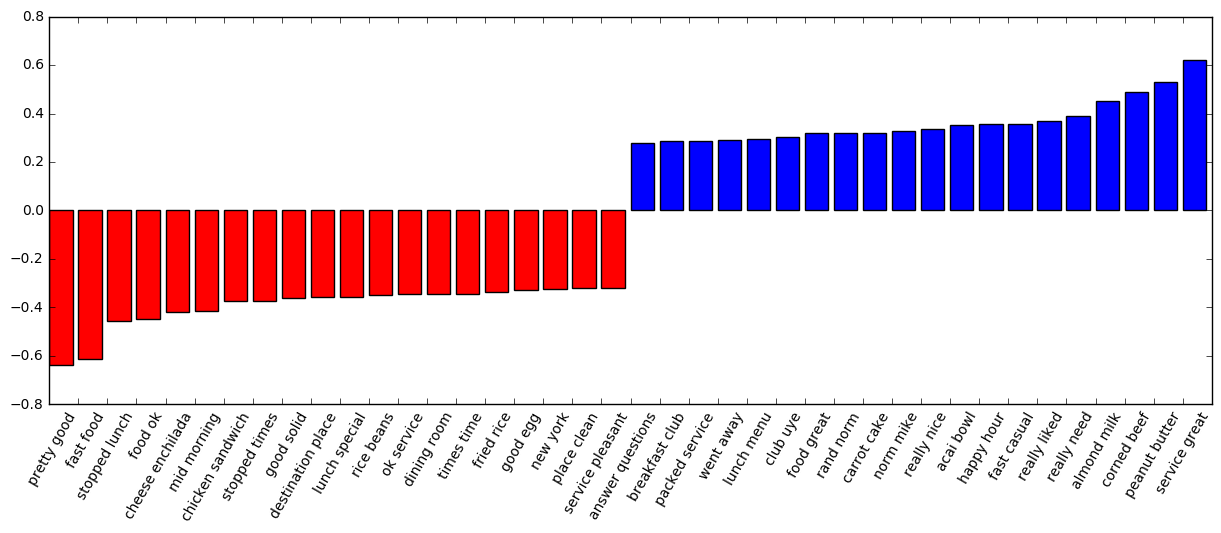

In [480]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
    
tfv = TfidfVectorizer(ngram_range = (2,2), stop_words = 'english')
tfv.fit(sub_train_reviews)

X_train = tfv.transform(sub_train_reviews)
ex_clf = svm.LinearSVC()
ex_clf.fit(X_train, train_labels)
yml.plot_coefficients(ex_clf, tfv.get_feature_names())

#### Let's take a look at the topics generated by LDA. Specifically, we focus only on the good reviews and plot the topics that appeared most often in the good reviews.

In [481]:
#Let's take a look at sample weightings for the user's GOOD reviews
good_reviews = [a for (a,b) in zip(sub_train_reviews, train_labels) if b == 1]
tf = vectorizer.fit(sub_train_reviews)
lda_fit = LatentDirichletAllocation(n_topics=50).fit(tf.transform(sub_train_reviews))

tf_good = tf.transform(good_reviews)
lda_good = lda_fit.transform(tf_good)

#Take the average of each topic weighting amongst good reviews and graph each topic
topic_strings = ["Topic " + str(x) for x in range(0,50)]

topic_dict = {}
for review in lda_good:
    for x in range(0,50):
        try:
            topic_dict[topic_strings[x]].append(review[x])
        except:
            topic_dict[topic_strings[x]] = [review[x]]
            
average_top_weight = {}
for x in range(0,50):
    average_top_weight[topic_strings[x]] = reduce(lambda x, y: x + y, topic_dict[topic_strings[x]]) 
    / len(topic_dict[topic_strings[x]])

/Users/robertsonwang/anaconda2/lib/python2.7/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


(0, 50)

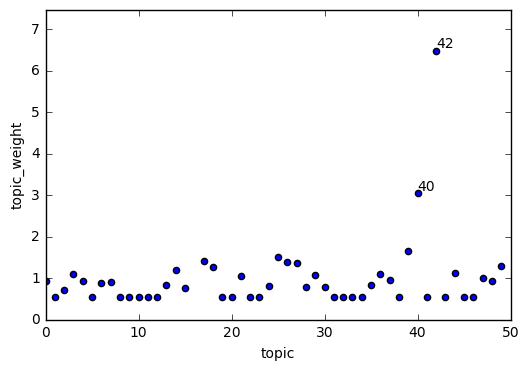

In [482]:
##############    
#Plot the average weights for each topic in the good reviews
##############     
#Find the average topic weights for each topic
average_topics = pd.DataFrame.from_dict(average_top_weight, orient = 'index')
average_topics.columns = ['topic_weight']
average_topics['topic'] = average_topics.index
average_topics['topic'] = [int(x[5:8]) for x in average_topics['topic']]
average_topics = average_topics.sort_values(['topic'])
x_max = average_topics.sort_values('topic_weight')['topic_weight'][-2] + 1

#Make the plot
good_plt = average_topics.plot(x='topic', y='topic_weight', kind='scatter', legend=False)
yml.label_point(average_topics.topic, average_topics.topic_weight, good_plt)
good_plt.set_ylim(0, x_max)
good_plt.set_xlim(0, 50)

#### Let's look at the top 5 words in each of these topics

In [483]:
#View the top words in the outlier topics from the LDA representation
yml.label_point(average_topics.topic, average_topics.topic_weight, good_plt)

a = pd.concat({'x': average_topics.topic, 
                   'y': average_topics.topic_weight}, axis=1)
top_topics = [a[a['y'] == max(a['y'])]['x'][0]]
a = a[a['y'] != max(a['y'])]
for i, point in a.iterrows():
    if (point['y'] > (a['y'].mean() + 1.5 * a['y'].std()) ):
        top_topics.append(int(point['x']))
            

#Display top words in each topic                     
no_top_words = 10
tf_feature_names = vectorizer.get_feature_names()

yml.display_topics(lda_fit, tf_feature_names, no_top_words, top_topics)

Topic 16:
good lunch place food got time really service just like
Topic 40:
4oz switch louis rack aquarium overdone flight replace gives tank
Topic 42:
lemonade time dining nears bump dont pig room knows limit


#### Next, let's take a look at what kind of restaurants the user likes 

In [484]:
good_restaurants = user_df[user_df['rating'] >= 4]['biz_id']
bis_data = db.get_collection('restaurants')
#Pull each restaurant attribute from the MongoDB
restreview_good = {}
for i in tqdm.tqdm(range(0, len(good_restaurants))):
    rlist = []
    for obj in bis_data.find({'business_id':business_ids[i]}):
        rlist.append(obj)
    restreview_good[business_ids[i]] = rlist

100%|██████████| 169/169 [00:02<00:00, 60.00it/s]


(0, 40)

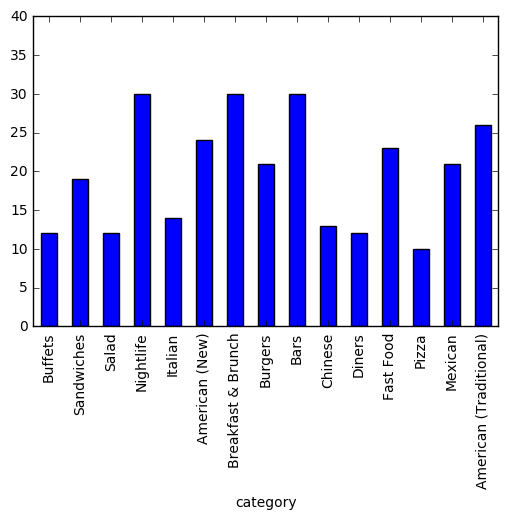

In [485]:
#Get all the categories for the good restaurants 
good_list = []
for key in restreview_good.keys():
    good_list.extend(restreview_good[key][0]['categories'])
good_list = [word for word in good_list if (word != u'Restaurants')]
good_list = [word for word in good_list if (word != u'Food')]
unique_categories = list(set(good_list))
category_count = [good_list.count(cat) for cat in unique_categories]
category_list = [(a,b) for (a,b) in zip(unique_categories, category_count) if b >= 10]
unique_categories = [a for (a,b) in category_list] 
category_count = [b for (a,b) in category_list]
biz_category = pd.DataFrame({'category': unique_categories, 'count': category_count})

#Plot only categories that show up at least 10 times
good_plt = biz_category.plot(x='category', y='count', kind='bar', legend=False)
good_plt.set_ylim(0,40)

The restaurants that we've recommended include many traditional and new American restaurants, as well as Burger places. This suggests that our recommendation system does a good job picking up on the latent preferences of the user.

With LSA, we arbitrarily chose the number of topics to be the mean of the singular values. This is a meaningless choice and completely arbitrary.

The words in the below representation represent word vectors in the initial term-document matrix, the coefficients on each word vector is a result of the singular value decomposition.

In [486]:
print "The number of LSA topics is: " + str(lsi.num_topics)
for x in lsi.show_topics():
    print str(x) + "\n"

The number of LSA topics is: 9
(0, u'0.125*"lunch" + 0.108*"place" + 0.107*"would" + 0.105*"got" + 0.100*"good" + 0.099*"one" + 0.095*"food" + 0.093*"time" + 0.087*"really" + 0.084*"salad"')

(1, u'-0.433*"pizza" + 0.229*"breakfast" + 0.115*"eggs" + 0.111*"stopped" + -0.110*"vegan" + -0.106*"youre" + 0.102*"morning" + -0.098*"salad" + 0.097*"ok" + -0.096*"crust"')

(2, u'-0.289*"breakfast" + -0.229*"pizza" + -0.202*"eggs" + -0.172*"morning" + 0.167*"lunch" + -0.144*"coffee" + -0.137*"gravy" + 0.123*"beans" + -0.109*"hash" + 0.108*"rice"')

(3, u'-0.318*"pizza" + 0.152*"sandwich" + 0.103*"youre" + 0.102*"bbq" + 0.098*"ive" + -0.095*"pasta" + 0.089*"theres" + 0.083*"chocolate" + -0.078*"ordered" + 0.076*"burger"')

(4, u'-0.370*"pizza" + -0.208*"sandwich" + -0.142*"always" + -0.142*"stopped" + -0.137*"times" + -0.137*"years" + -0.119*"pasta" + -0.115*"ok" + -0.110*"lunch" + 0.102*"group"')

(5, u'0.267*"burger" + 0.182*"fries" + -0.178*"lunch" + -0.128*"rand" + -0.127*"rice" + 0.119*"oni

In [487]:
#Let's take a look at sample weightings for the user's GOOD reviews
good_reviews = [a for (a,b) in zip(sub_train_reviews, train_labels) if b == 1]
lsi, topics, dictionary = yml.fit_lsi(good_reviews)
train_lsi = yml.get_lsi_features(good_reviews, lsi, topics, dictionary).todense()
train_lsi = [np.array(x[0])[0] for x in train_lsi]

#Take the average of each topic weighting amongst good reviews and graph each topic
lsi_topic_strings = ["Topic " + str(x) for x in range(0,9)]

lsi_topic_dict = {}
for review in train_lsi:
    for x in range(0,9):
        try:
            lsi_topic_dict[lsi_topic_strings[x]].append(review[x])
        except:
            lsi_topic_dict[lsi_topic_strings[x]] = [review[x]]
            
average_lsi_weight = {}
for x in range(0,9):
    average_lsi_weight[lsi_topic_strings[x]] = reduce(lambda x, y: x + y, 
                                                      lsi_topic_dict[lsi_topic_strings[x]]) 
    / len(lsi_topic_dict[lsi_topic_strings[x]])

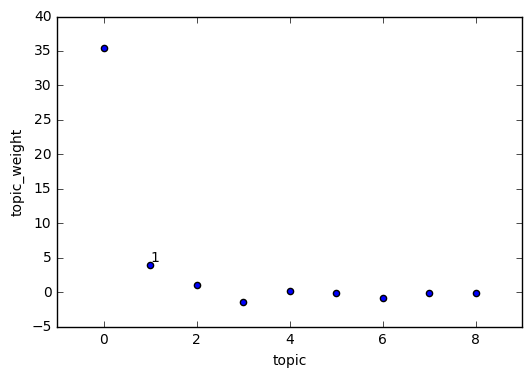

In [493]:
##############    
#Plot the average weights for each topic in the good reviews
##############     
#Find the average topic weights for each topic
lsi_average_topics = pd.DataFrame.from_dict(average_lsi_weight, orient = 'index')
lsi_average_topics.columns = ['topic_weight']
lsi_average_topics['topic'] = lsi_average_topics.index
lsi_average_topics['topic'] = [int(x[5:8]) for x in lsi_average_topics['topic']]
lsi_average_topics = lsi_average_topics.sort_values(['topic'])
x_max = lsi_average_topics.sort_values('topic_weight')['topic_weight'][-2] + 1

#Make the plot
lsi_good_plt = lsi_average_topics.plot(x='topic', y='topic_weight', kind='scatter', legend=False)
yml.label_point(lsi_average_topics.topic, lsi_average_topics.topic_weight, lsi_good_plt)